In [2]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import numpy as np
import matplotlib.pyplot       as plt

In [3]:
# load the handwriting OCR model
print("[INFO] loading handwriting OCR model...")
model = load_model("model_HandWrite.h5")

[INFO] loading handwriting OCR model...


(0.0, 256.0, 0.0, 0.04)

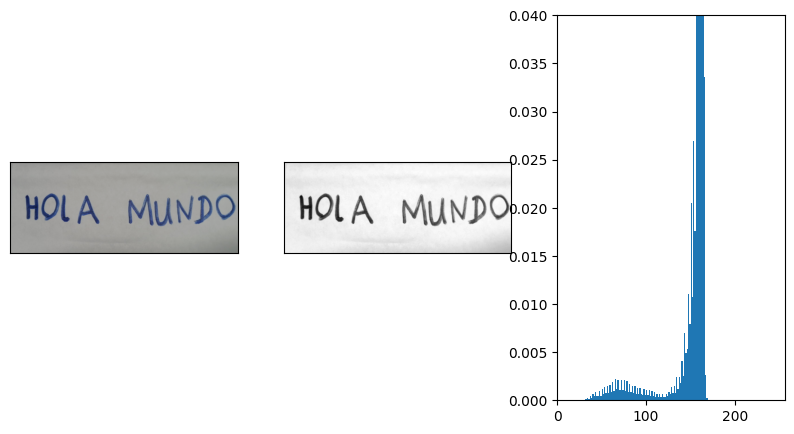

In [12]:
# cargar la imagen, normalizar, pasar a gris y aplicar filtro gausiano

image = cv2.imread("image3.jpeg")
image = cv2.normalize(image, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(10, 5)) 
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

plt.subplot(132)
plt.imshow(blurred, cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

plt.subplot(133)
b=plt.hist(blurred.ravel(),100,density=True)

plt.axis([0,256,0,0.04])

Iniciar el procesamiento para poder aislar cada letra
1. aplicar umbral

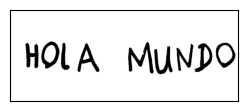

In [5]:
plt.figure(figsize=(10, 5)) 
_, thr = cv2.threshold(blurred,120, 255, cv2.THRESH_BINARY)
plt.subplot(132)
plt.imshow(thr, cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)


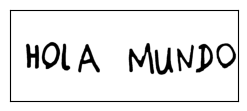

In [144]:
# aplicar filtro morfologico de cierre
kernel = np.ones((10,10),np.uint8)


#thr = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel)
thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(10, 5)) 
plt.subplot(132)
plt.imshow(thr, cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)


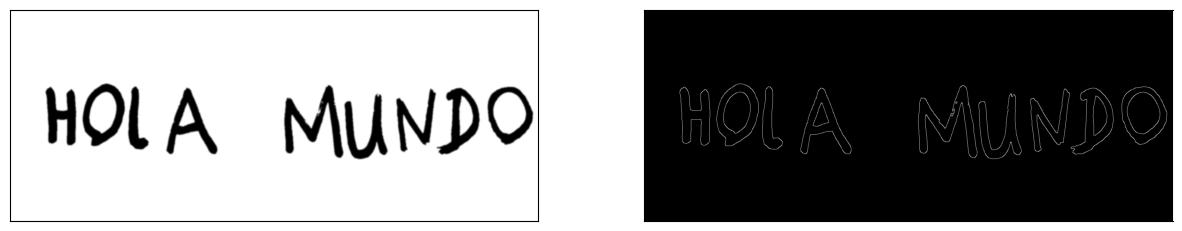

In [6]:

thr = cv2.GaussianBlur(thr, (9, 9), 0)    
# aplicar deteccion de bordes y encontrar contornos
#ordenar contornos de izquierda a derecha
edged = cv2.Canny(thr, 50, 200)
cnts = cv2.findContours(255-thr.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

plt.figure(figsize=(15, 5)) 

plt.subplot(121)
plt.imshow(thr,cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)


plt.subplot(122)
plt.imshow(edged,cmap="gray");
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)


In [7]:
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    print(w,h)
    if (w >= 5 and w <= 200) and (h >= 15 and h <= 230):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        # if the width is greater than the height, resize along the
        # width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)
        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)
        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 32x32
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)
        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0))
        padded = cv2.resize(padded, (28, 28))
        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")        

100 184
135 196
69 197
162 207
186 227
138 205
127 199
137 208
145 182


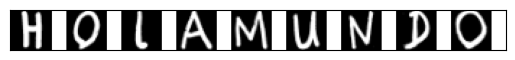

In [11]:
images =  np.zeros((28,1))
bar    =  np.ones((28,10))
for i in range(chars.shape[0]):
    x = chars[i]    
    images=np.append(images,x[:,:,0],axis=1)
    images=np.append(images,bar,axis=1)

    
plt.imshow(images,cmap="gray");
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False) 


In [9]:
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

1/1 [==============================] - 0s 176ms/step


[INFO] H - 99.94%
[INFO] 0 - 64.93%
[INFO] L - 96.91%
[INFO] A - 99.95%
[INFO] M - 99.96%
[INFO] U - 99.97%
[INFO] N - 99.91%
[INFO] D - 99.99%
[INFO] 0 - 58.93%


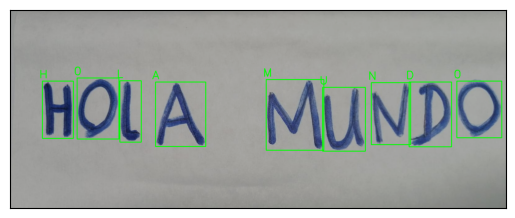

In [13]:
# iterar sobre las predicciones y los recuadros de cada letra detectada
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # hacer la prediccion con la probabilidad mas grande y asignar la etiqueta
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # dibujar la prediccion
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    # show the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)


https://towardsdatascience.com/segmentation-in-ocr-10de176cf373
https://nkhandelwal204.medium.com/character-segmentation-using-opencv-and-python-3bf582d9c626